# LangChain (Legacy)

In [5]:
# SubAgents

from langchain.tools import tool
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import f
import pandas as pd
import numpy as np
from scipy.linalg import eigh

def calculate_PC(data):
    '''
    Calculate the principal components of the input data
    '''
    mu = data.to_numpy().mean(axis=0)
    std = data.to_numpy().std(axis=0)

    standardized_data = (data.to_numpy()-mu)/std
    cov_matrix = np.cov(standardized_data, rowvar=False)

    eigenvalue,eigenvector = eigh(cov_matrix)
    eigenvalue = eigenvalue[::-1]
    eigenvector = eigenvector[:,::-1]

    # Apply 1st 2 principal components to the dataset
    transformed_data = standardized_data @ np.vstack((eigenvector[:,0], eigenvector[:,1])).T
    
    pc1 = transformed_data[:,0].tolist()
    pc2 = transformed_data[:,1].tolist()

    return [pc1,pc2] 


def levene_test(data):
    ''' 
    Calculate the equality of variances for 2 or more groups | F(1-aplha, N-k)
    
    Args:
    data (pd.dataframe): dataframe of groups
    k (int): numner of different groups to which the sampled case belong
    N (int): total number of cases in all groups
    Ni (int): number of cases in the ith group
    Yij (array): the value of the measured variable for the jth case from the ith group
    Zij (float): the mean or median of the ith group
    Zi (float): is the mean of the Zij for group i
    Z (float): is the mean of all Zij

    Return:
    W (float): F statistic 0.05
    pval (float): p value
    '''
    data = np.array(data).T

    N = data.shape[0]*data.shape[1]
    k = data.shape[1]
    Ni = data.shape[0]

    Zij = [np.abs(data.T[i]-data.T[i].mean()) for i in range(k)]

    Zi = [np.divide(1,Ni)*np.sum(Zij[i]) for i in range(k)]

    Z = np.divide(1,N)*np.sum([np.sum(Zij[i]) for i in range(k)])

    W = np.divide((N-k),(k-1))*np.divide(np.sum(Ni*(Zi-Z)**2),np.sum([np.sum((Zij[i]-Zi[i])**2) for i in range(k)]))
    
    pval = 1-f.cdf(W,k-1,N-k)

    return W, pval

def anova_one_way(dd):
    '''     
    Args:
    X (float): overall mean
    Xj (float): mean of group j
    n (int): sample size of group j
    Xij = the ith observation in group j

    '''

    k = dd.shape[1]
    n = dd.shape[0]
    N = k*n

    X = np.array([dd[col].mean() for col in dd.columns]).mean()
    Xj = np.array([dd[col].mean() for col in dd.columns])
    Xij = np.array([dd[col]for col in dd.columns])

    SSR = n*np.sum((Xj-X)**2) # Regression sum of squares
    SSE = np.sum([np.sum((Xij[i]-Xj[i])**2) for i in range(len(Xj))]) # Error sum of squares
    SST = SSR+SSE # Total sum of squares

    df1 = k-1
    df2 = N-k

    MS = SSR/df1 # Mean squares
    MSE = SSE/df2 # Mean square error
    F = MS/MSE # F-statistic
    pval = 1-f.cdf(F,k-1,N-k)
    return F, pval

@tool
def get_columns(col_input) -> list:
    '''
    Pull columns to perform statistics on
    '''
    if col_input == "all" or "*":
       
        columns = df.columns.to_list()
        return columns

@tool
def covariance_tool(columns: str):
    '''
    Calculate the covariance of the columns of data 

    Args:
    columns (str): list of columns to perform covariance calculation

    Return:
    Response with the calculated covariance matrix
    '''

    columns = [col.strip().strip('"').strip("'") for col in columns.split(',')]

    
    missing = [col for col in columns if col not in df.columns]
    if missing:
        return f'Columns not found: {','.join(missing)}'
    cov_matrix = df[columns].cov()
    return f' Covariance Matrix: \n{cov_matrix.to_string()}'

@tool
def correlation_tool(columns: str):
    '''
    Calculate the correlation of the columns of data

    Args:
    columns (str): list of columns to perform correlation calculation on

    Return:
    Response with the calculated correlation matrix
    '''

    columns = [col.strip().strip('"').strip("'") for col in columns.split(',')]

    missing = [col for col in columns if col not in df.columns]
    if missing:
        return f'Columns not found: {','.join(missing)}'
    corr_matrix = df[columns].corr()
    return f'Correlation Matrix: {corr_matrix.to_string()}'

@tool
def normality_tool(columns: str):
    '''
    Calculate if the input data is normal

    Args:
    df (pd.dataframe): dataframe containig raw data

    Return:
    Response on whether data is normal or not, explicitly stating which columns are not
    '''

    columns = [col.strip().strip('"').strip("'") for col in columns.split(',')]

    missing = [col for col in columns if col not in df.columns]
    if missing:
        return f'Columns not found: {','.join(missing)}'

    not_normal = []

    for col in columns:
        tstat, pval = shapiro(df[col])
        if pval < 0.05: # reject H0
            not_normal.append(col)
            return f'Column {col} is not normally distributed, and not recommended to include in ANOVA analysis'
    return f'Data is normal'

@tool
def levene_test_tool(columns: str):
    ''' 
    Calculate the equality of variances for 2 or more groups | F(1-aplha, N-k)
    '''

    columns = [col.strip().strip('"').strip("'") for col in columns.split(',')]

    missing = [col for col in columns if col not in df.columns]
    if missing:
        return f'Columns not found: {','.join(missing)}'
    

    data = df[columns]
    

    return levene_test(data)

@tool    
def calculate_ANOVA_tool(columns: str):
    '''
    Compare the means of 3 or more independant groups to determine statistical difference between popuplaiton means.
    H0: The mean of the independent groups are all the same, there is no statistical difference. difference is due to random sampling from same population
    Test for normality within ea group with shapiro-wilks test (H0: data was drawn from a normal distribution) pval < 0.05 reject H0
    Test for homegenity of variance with levene test (H0: data has equal variance) p_val < 0.05 reject H0 at lease 1 of the groups is not heteroskedastic Anova can be used
    H0: two or more groups have the same population mean
    Calculate the amount of variance between groups means to the amount of variation within each group  group variation > within group variation => difference in mean not random
    '''

    columns = [col.strip().strip('"').strip("'") for col in columns.split(',')]

    missing = [col for col in columns if col not in df.columns]
    if missing:
        return f'Columns not found: {','.join(missing)}'
    

    data = df[columns]
    

    return anova_one_way(data)

@tool
def PCA_tool(columns: str) ->list:
    '''
    Calculates the 1st two principal components of a dataset
    '''

    columns = [col.strip().strip('"').strip("'") for col in columns.split(',')]

    
    return calculate_PC(df[columns])

@tool
def plot_data(mylist: str):
    '''
    Create a scatter plot 
    '''
    import matplotlib.pyplot as plt 
    import ast
    
    mylist = mylist.strip('" "')
    mylist = ast.literal_eval(mylist)
    pc1 = np.array(mylist[0])
    pc2 = np.array(mylist[1])



    plt.scatter(pc1,pc2)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    # plt.savefig("pca_result.png")
    plt.show()
    return "PCA plot saved to pca_result.png"




In [6]:
from langchain.agents import initialize_agent, AgentType
from langchain_community.chat_models import BedrockChat
from langchain.memory import ConversationBufferMemory

def stat_agent():
    ''' 
    One-shot Stat Agent
    '''
    memory = ConversationBufferMemory(memory_key='chat_history', return_message=True)
    llm = BedrockChat(model_id='anthropic.claude-3-5-sonnet-20240620-v1:0', region_name='us-east-1', model_kwargs={'max_tokens': 3000, 'temperature': 0})

    sub_agent = [covariance_tool, correlation_tool, normality_tool, levene_test_tool, get_columns, calculate_ANOVA_tool, PCA_tool, plot_data]

    agent = initialize_agent(
        tools=sub_agent,
        llm=llm,
        agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
        verbose=True,
        memory=memory,
        agent_kwargs={'system_message': 'You are a Statistics agent '}
    )
    return agent







> Entering new AgentExecutor chain...
To answer this question, we need to follow these steps:
1. Get all the columns from the dataframe
2. Calculate the principal components using those columns
3. Create a scatter plot of the first two principal components

Let's start by getting all the columns.

Action: get_columns
Action Input: all

Observation: ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12']
Thought:Thought: Great, we now have all the columns from the dataframe. Let's proceed to calculate the principal components using these columns.

Action: PCA_tool
Action Input: A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12

Observation: [[-0.8279801125859166, -1.8748439208408938, -0.9639972848511256, 1.7064715093789355, -3.6744507475269517, 1.5901198630406577, -0.9601324619449173, -2.396304548886548, 0.6049511023882359, 0.20410869888477098, 0.9799686007125507, -0.9871319474789305, -0.25313220664264363, 2.976108725682672, 3.49654431783284, -0.040739748525881705, -

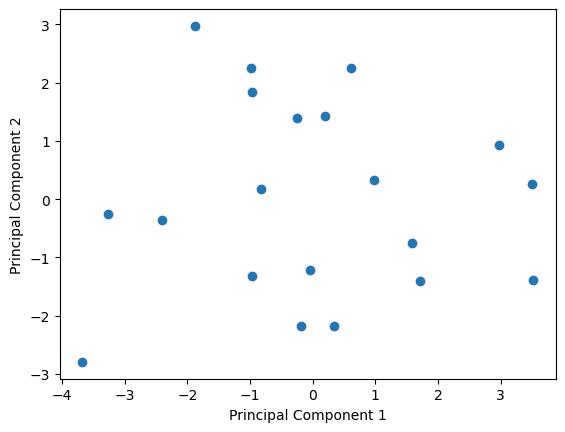


Observation: PCA plot saved to pca_result.png
Thought:Thought: Great! We have successfully completed all the steps required to answer the question. Let's summarize what we've done:

1. We retrieved all the columns from the dataframe using the get_columns tool.
2. We calculated the principal components using the PCA_tool with all the columns.
3. We created a scatter plot of the first two principal components using the plot_data tool.

Now we can provide the final answer.

Final Answer: We have successfully retrieved all columns from the dataframe, calculated the principal components, and created a scatter plot of the two principal components. The scatter plot has been saved as 'pca_result.png'. This plot visualizes the data points in the space of the first two principal components, which represent the directions of maximum variance in the dataset. Each point in the plot represents an observation from the original dataset, projected onto the plane defined by the first two principal comp

{'input': 'Get all the columns from df and calculate the principal components then create a scatter plot of the 2 different principal components',
 'chat_history': '',
 'output': "We have successfully retrieved all columns from the dataframe, calculated the principal components, and created a scatter plot of the two principal components. The scatter plot has been saved as 'pca_result.png'. This plot visualizes the data points in the space of the first two principal components, which represent the directions of maximum variance in the dataset. Each point in the plot represents an observation from the original dataset, projected onto the plane defined by the first two principal components. This visualization can help identify patterns, clusters, or outliers in the high-dimensional data that might not be apparent in the original feature space."}

In [7]:
from sklearn.datasets import load_wine

stat_agent = stat_agent()
# df = pd.read_csv('sample_df.csv')
data = load_wine()
lbl = data['target_names']
header = [a+str(n) for n,a in enumerate(np.repeat('A',data['data'].shape[1]))]
df = pd.DataFrame(data['data'], columns=header)
df = df.iloc[:20,:]

stat_agent.invoke('Get all the columns from df and calculate the principal components then create a scatter plot of the 2 different principal components')

